<a href="https://colab.research.google.com/github/sdd261/time-series/blob/main/temprature-forcasting-using-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv('/content/DailyDelhiClimateTrain.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
df.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [5]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [6]:
#Set Date column as an index

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace= True)


In [7]:
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


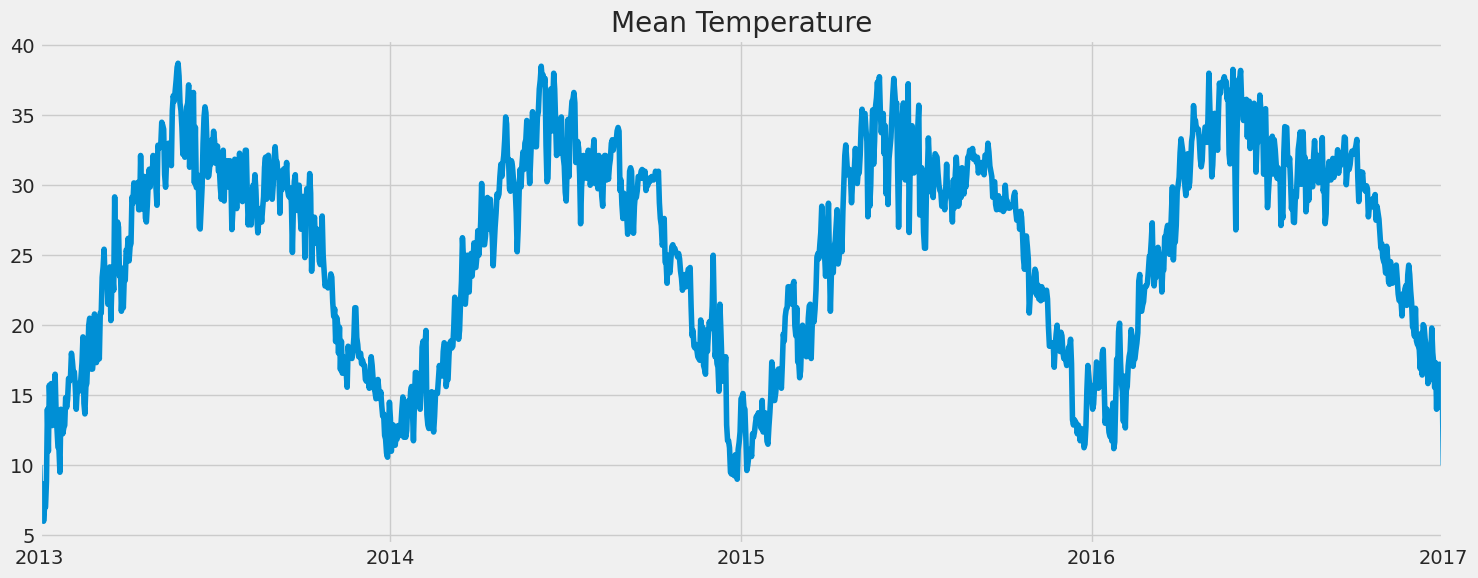

In [8]:
plt.figure(figsize=(15, 6))
df['meantemp'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Mean Temperature")
plt.tight_layout()
plt.show()

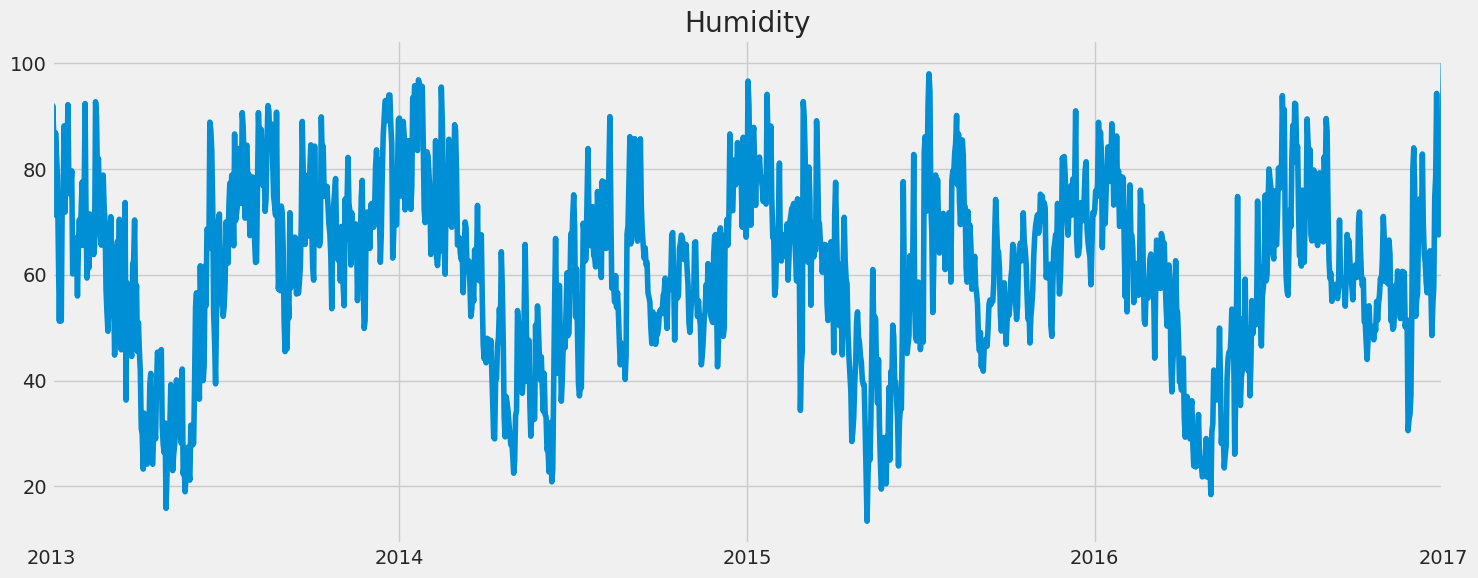

In [9]:
plt.figure(figsize=(15, 6))
df['humidity'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Humidity")
plt.tight_layout()
plt.show()


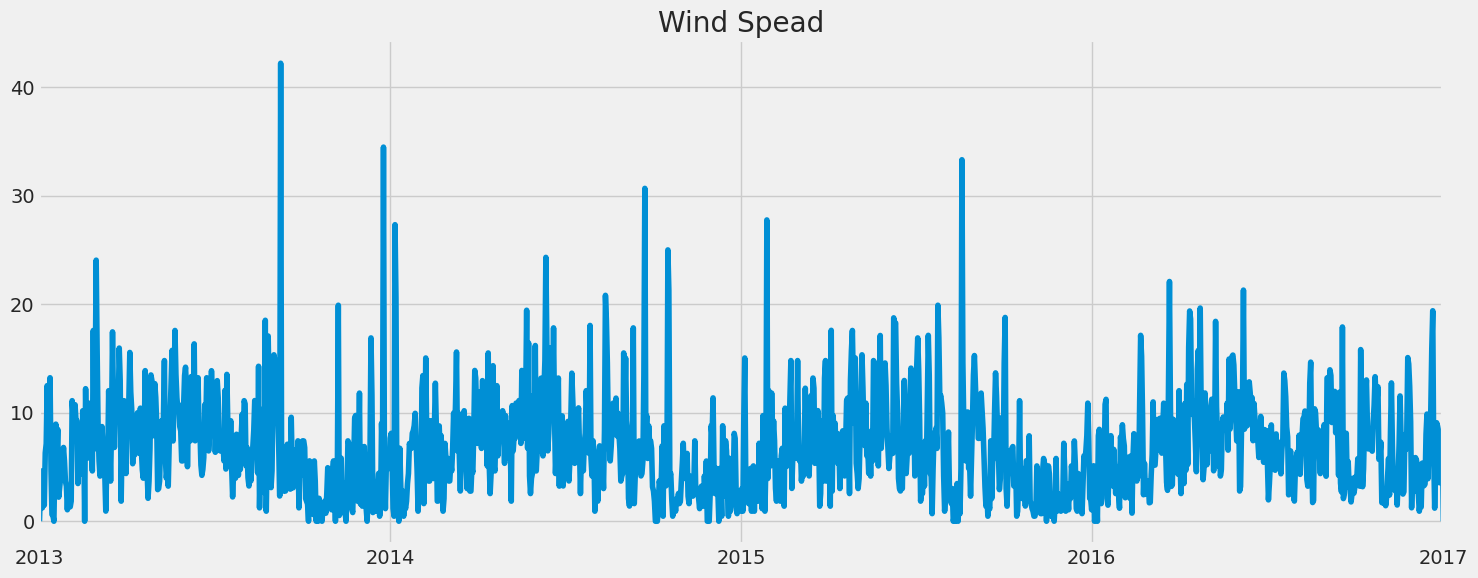

In [10]:
plt.figure(figsize=(15, 6))
df['wind_speed'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Wind Spead")
plt.tight_layout()
plt.show()

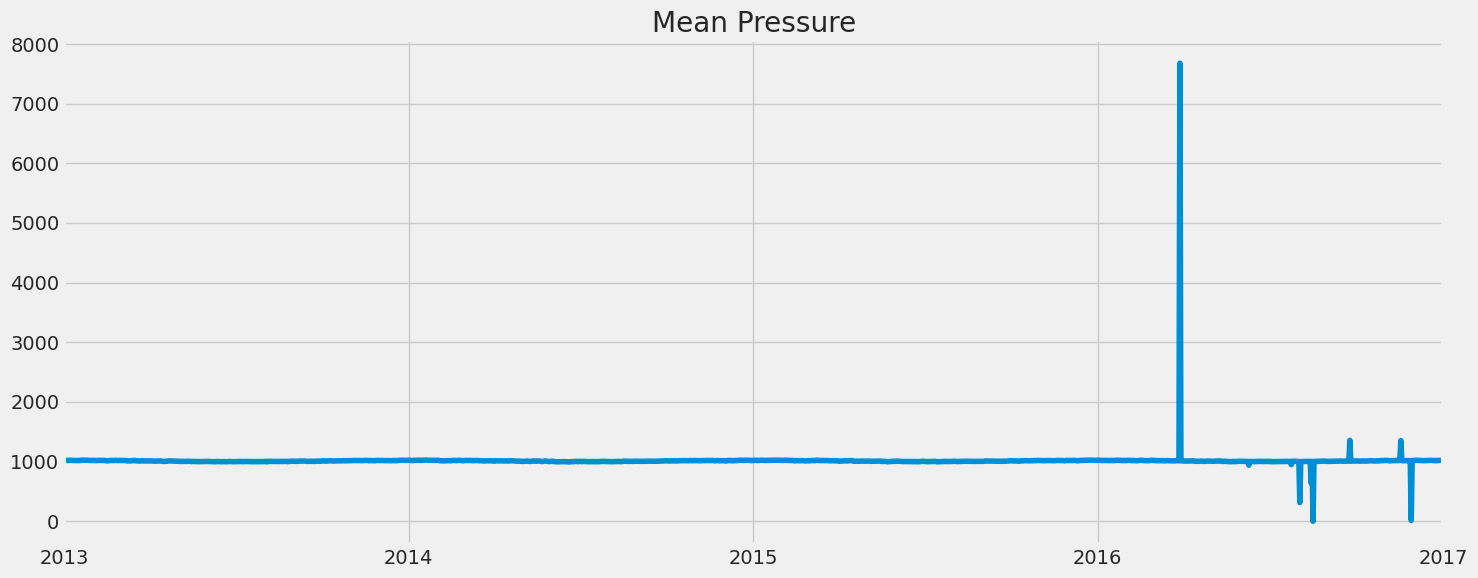

In [11]:
plt.figure(figsize=(15, 6))
df['meanpressure'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Mean Pressure")
plt.tight_layout()
plt.show()

In [12]:
#prediction column(temprature)
n_cols = 1
dataset = df["meantemp"]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(1462, 1)

In [13]:
#normlize data
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

In [16]:
#Splitting Data

train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 1096 Test Size : 366


In [17]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(1096, 1)

In [19]:
# Creating a Training set with 60 time-steps(days)
x_train = []
y_train = []
time_steps = 60
n_cols = 1

for i in range(time_steps, len(scaled_data)):
    x_train.append(scaled_data[i-time_steps:i, :n_cols])
    y_train.append(scaled_data[i, :n_cols])

In [20]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [21]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

In [22]:
x_train.shape , y_train.shape

((1402, 60, 1), (1402, 1))

# LSTM model

In [24]:
# Define the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], n_cols)),  # First LSTM layer
    LSTM(64, return_sequences=False),  # Second LSTM layer, no sequence output needed as it's the last LSTM layer
    Dense(32, activation='relu'),  # Dense layer with 32 units and ReLU activation
    Dense(16, activation='relu'),  # Dense layer with 16 units and ReLU activation
    Dense(n_cols)  # Output layer with n_cols units (to match target shape)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Metrics is provided as a list with 'mae' (mean absolute error)


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Fitting the LSTM to the Training set
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.1246 - mae: 0.2674
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0072 - mae: 0.0682
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0056 - mae: 0.0592
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0049 - mae: 0.0557
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0052 - mae: 0.0573
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0058 - mae: 0.0595
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0048 - mae: 0.0543
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0047 - mae: 0.0542
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0048 - mae: 0.0552
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0046 - mae: 0.0533
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0047 - mae: 0.0532
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0043 - mae: 0.0516
Epoch 13/100
44/44 ━━━━━━

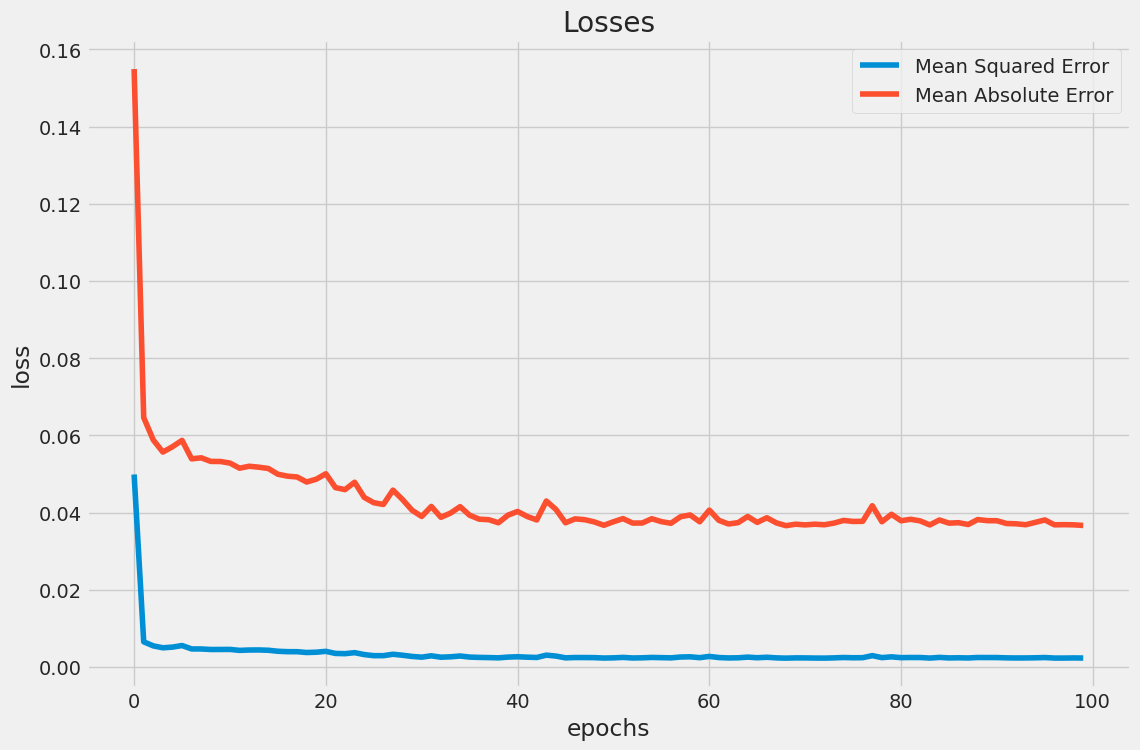

In [27]:
#model evaluation
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mae"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [28]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [29]:
# Get Prediction
predictions = model.predict(x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [30]:
predictions.shape

(366, 1)

In [31]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(366, 1)

In [32]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)

In [33]:
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

0.94

In [34]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,14.418534,14.000000
1,13.946334,14.375000
2,14.054700,15.750000
3,14.948058,15.833333
4,15.271978,17.375000
...,...,...
361,16.340393,17.217391
362,16.597483,15.238095
363,15.369411,14.095238
364,14.269197,15.052632


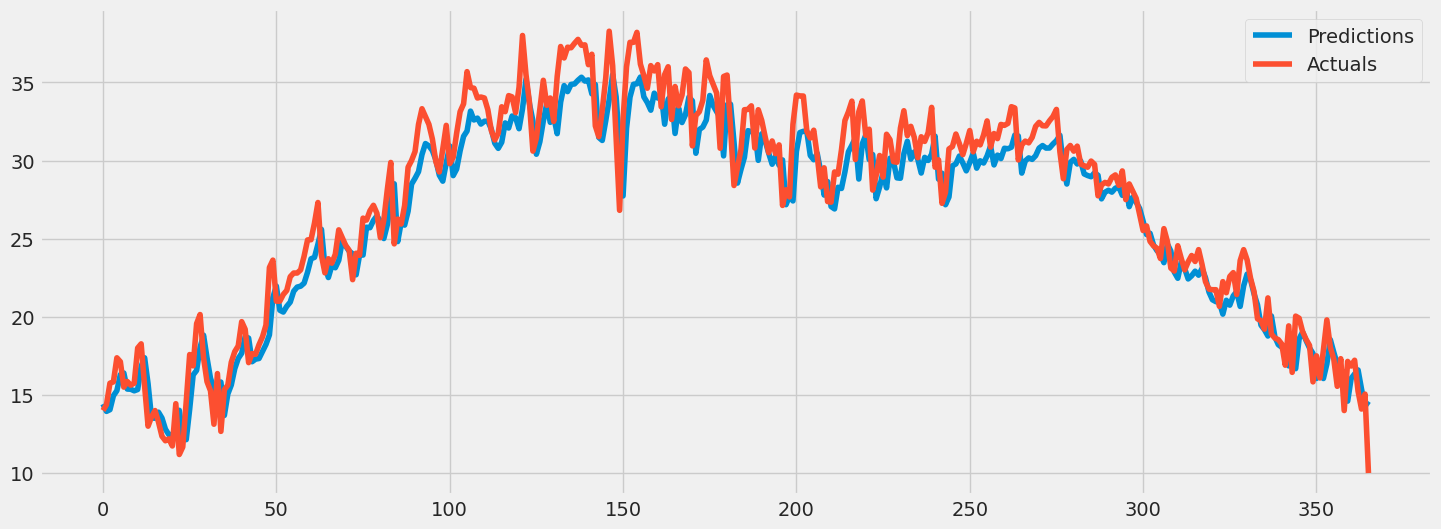

In [35]:
plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

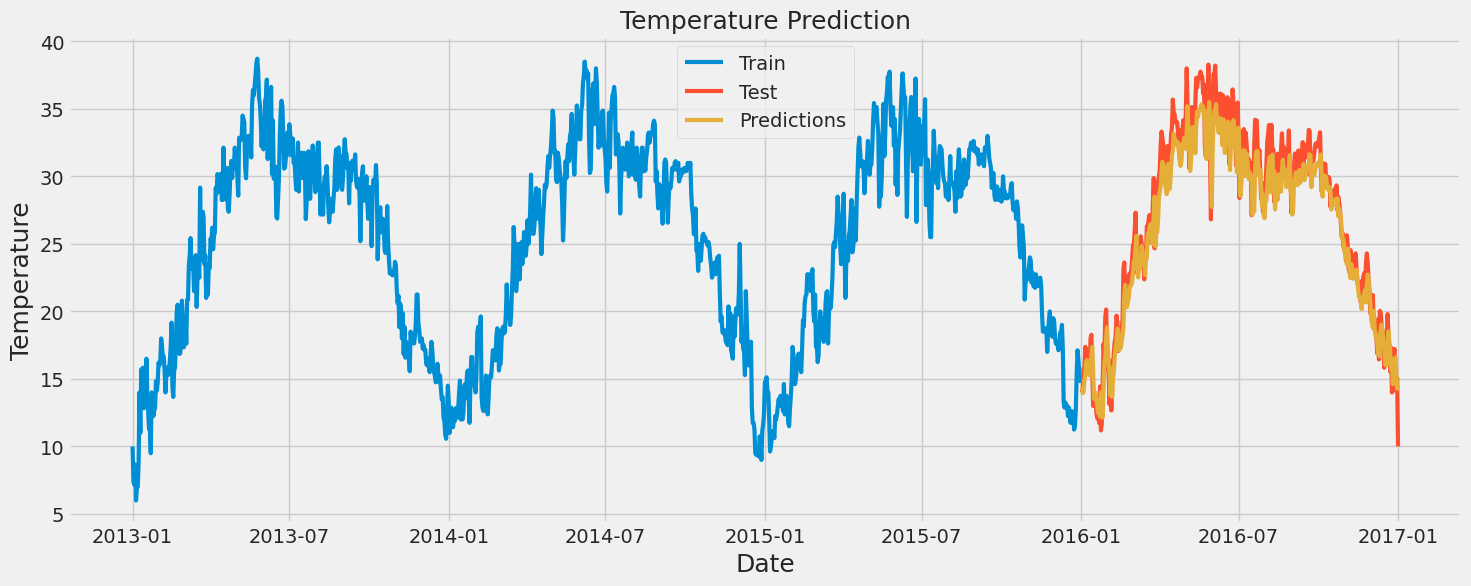

In [36]:
#Visualize Predictions with The Data(for one feature)
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Temperature Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train['meantemp'], linewidth= 3)
plt.plot(test['meantemp'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])